In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=1

In [3]:
import sys
import time
from functools import partial 
from collections import defaultdict

import jax
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)

In [4]:
import modules.utils
import modules.datasets

# Find GPU Devices

In [5]:
gpus = jax.devices('gpu')
gpus

[GpuDevice(id=0), GpuDevice(id=1)]

# Random Seed

In [6]:
random_key = random.PRNGKey(42)

# Data Handler

In [7]:
_BATCH_SIZE = 256

Files already downloaded and verified
(256, 3, 32, 32) (256, 10)


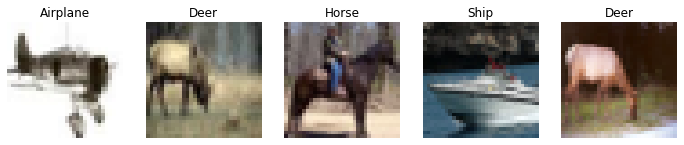

In [8]:
datahandler_key = 'pytorch' # 'pytorch', 'tensorflow'

base_params = {
    "download_dir" : "/tmp/dataset",
    "dataset_name" : "CIFAR10", # options: MNIST, CIFAR10
    "batch_size"   : _BATCH_SIZE,
    "flatten_img"  : False,
    "onehot_label" : True
}
data_handler = modules.datasets.BuildDataHandler(datahandler_key, **base_params)

for x, y in data_handler('train'):
    print(x.shape, y.shape)
    break
    
modules.utils.show_samples(data_handler, 5)

# Model - Convolutional Neural Network

We could continue in a similar low-level manner for building out CNNs as we have for the MLP, where we initialize kernels and setup the convolution operations using [`jax.lax.conv_general_dilated`](https://jax.readthedocs.io/en/test-docs/_autosummary/jax.lax.conv_general_dilated.html). However, as in Pytorch, Keras, and more recent versions of TF, JAX has an api for building models sequential with abstracted layers (Conv, Dense, etc.):  [`jax.experimental.stax.serial`](https://jax.readthedocs.io/en/latest/jax.experimental.stax.html)

Constructing the model this way yields two objects, the initialization function, `init_fun`, and the update function, `conv_net` (aka our feedforward pass). Read more [here](https://jax.readthedocs.io/en/latest/jax.experimental.stax.html#jax.experimental.stax.serial).

Only minimal changes are required to our MLP code, and our structure follows:
1. Network Initialization + Forward Pass
2. Loss Function
3. Backward Pass
4. Evaluation

## Fxn 1: Network Initialization + Forward Pass

In [20]:
def initialize_params(random_key, batch_size, num_classes, img_dim):
    init_fun, conv_net = stax.serial(
        Conv(32, (5, 5), (2, 2), padding="SAME"),
        BatchNorm(), Relu,
        Conv(32, (5, 5), (2, 2), padding="SAME"),
        BatchNorm(), Relu,
        Conv(10, (3, 3), (2, 2), padding="SAME"),
        BatchNorm(), Relu,
        Conv(10, (3, 3), (2, 2), padding="SAME"), Relu,
        Flatten,
        Dense(num_classes),
        LogSoftmax
    )

    _, params = init_fun(random_key, (batch_size, *img_dim))
    return conv_net, params

## Fxn Set 2: Loss

In [15]:
def loss_fxn(params, images, targets):
    preds = conv_net(params, images)
    return -np.mean(preds * targets)

## Fxn Set 3: Backward Pass Update

In [16]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss_fxn)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

## Fxn Set 4: Evaluation

In [17]:
def accuracy(conv_net, params, data_handler, dataset_key):
    """ Compute the accuracy for a provided dataloader """
    n_batches = data_handler.num_batches(dataset_key)
    acc_total = 0
    for batch_idx, (images, targets) in enumerate(data_handler(dataset_key)):
        # Stdout
        sys.stdout.write(f'\r\tEvaluating {dataset_key} set | Batch {batch_idx+1}/{n_batches}...')
        sys.stdout.flush()
        
        # Compute target class
        target_class = np.argmax(targets, axis=1)
        
        # Model Inference
        predicted_class = np.argmax(conv_net(params, images), axis=1)
        
        # Aggregate
        acc_total += np.sum(predicted_class == target_class)
    return acc_total / data_handler.size(dataset_key)

def evaluate(step_i, conv_net, params, data_handler, accuracies):
    print("\nEvaluation Phase.")
    for dataset_key in ['train', 'test']:
        acc = accuracy(conv_net, params, data_handler, dataset_key) 
        accuracies[dataset_key].append((step_i, acc))
    print("\n")

# Training Loop

In [18]:
def run_training_loop(data_handler, n_epochs, conv_net, opt_state, eval_freq):
    """ Implements a learning loop over epochs. """
    # Metric containers
    accuracies = defaultdict(list)
    train_loss = []
    
    # Get the initial set of parameters 
    params = get_params(opt_state)
    
    # Init evaluation
    evaluate(0, conv_net, params, data_handler, accuracies)
    
    # Compute num train batches
    n_train_batches = data_handler.num_batches('train')
    
    # Loop over the training epochs
    for epoch_i in range(n_epochs):
        print("Training Phase.")
        for batch_i, (data, target) in enumerate(data_handler('train')):
            
            # Forward pass + Backprop 
            params, opt_state, loss_val = update(params, data, target, opt_state)
            
            # Update loss container
            train_loss.append((epoch_i*n_train_batches+batch_i, loss_val))
            
            # Stdout
            stdout_str = f"\r\tEpoch {epoch_i+1}/{n_epochs} -- "
            stdout_str += f"Batch {batch_i}/{n_train_batches} -- Loss: {loss_val:0.2f}..."
            sys.stdout.write(stdout_str)
            sys.stdout.flush()
        
        # Evaluate
        if (epoch_i+1) % eval_freq == 0:
            evaluate(epoch_i, conv_net, params, data_handler, accuracies)
    
    return train_loss, accuracies

In [19]:
_N_EPOCHS = 10
_EVAL_FREQ = 1
_LEARNING_RATE = 1e-3

# Initialize the conv net
# Set global for loss_fxn to have access - cannot pass conv_net through 
# If you find a better way, please let me know!
global conv_net
conv_net, params = initialize_params(random_key, _BATCH_SIZE, data_handler.num_classes, data_handler.img_dim)

# Place on device
jax.device_put(params, device=gpus[0])

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(_LEARNING_RATE)
opt_state = opt_init(params)

train_loss, accuracies = run_training_loop(data_handler,
                                           _N_EPOCHS,
                                           conv_net,
                                           opt_state,
                                           _EVAL_FREQ)


Evaluation Phase.
	Evaluating test set | Batch 40/40......

Training Phase.
	Epoch 1/10 -- Batch 195/196 -- Loss: 0.16...
Evaluation Phase.
	Evaluating test set | Batch 40/40......

Training Phase.
	Epoch 2/10 -- Batch 195/196 -- Loss: 0.13...
Evaluation Phase.
	Evaluating test set | Batch 40/40......

Training Phase.
	Epoch 3/10 -- Batch 195/196 -- Loss: 0.13...
Evaluation Phase.
	Evaluating test set | Batch 40/40......

Training Phase.
	Epoch 4/10 -- Batch 195/196 -- Loss: 0.14...
Evaluation Phase.
	Evaluating test set | Batch 40/40......

Training Phase.
	Epoch 5/10 -- Batch 195/196 -- Loss: 0.13...
Evaluation Phase.
	Evaluating test set | Batch 40/40......

Training Phase.
	Epoch 6/10 -- Batch 195/196 -- Loss: 0.12...
Evaluation Phase.
	Evaluating test set | Batch 40/40......

Training Phase.
	Epoch 7/10 -- Batch 195/196 -- Loss: 0.12...
Evaluation Phase.
	Evaluating test set | Batch 40/40......

Training Phase.
	Epoch 8/10 -- Batch 195/196 -- Loss: 0.12...
Evaluation Phase.
	Eval

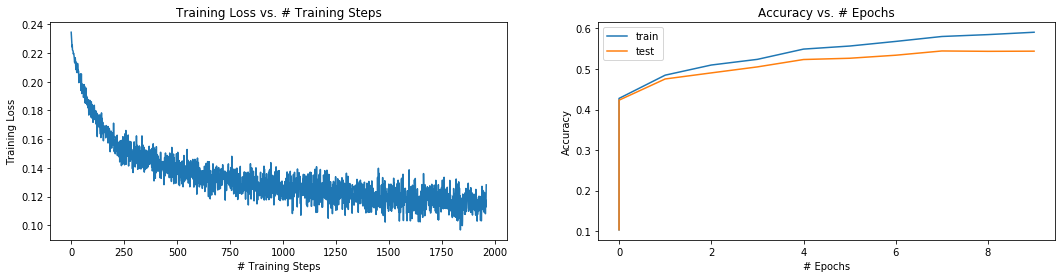

In [21]:
modules.utils.plot_metrics(train_loss, accuracies)